# **Лабораторна робота №3 “Кластеризація”**
**Виконав студент групи КН-31, Бенза Роман Анатолійович.**

**Мета:** 
ознайомитися з методами **кластеризації** (clustering) на прикладі реального набору музичних даних **Spotify Tracks Dataset**. Навчитись підбирати оптимальну кількість кластерів (k) за допомогою методу ліктя **(elbow)**, виконувати кластеризацію методом **K-Means**, знижувати розмірність простору ознак за допомогою **PCA** для візуалізації та аналізувати характеристики утворених кластерів.

**Джерело даних:** 
[Spotify Tracks Dataset](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db).


**Хід роботи:**
1. Завантаження та підготовка даних.
2. Підбір оптимальної кількості кластерів (k) — метод ліктя.
3. Побудова кластеризації.
4. Візуалізація кластерів у просторі головних компонент.
5. Аналіз кластерів.


## **1. Завантаження та підготовка даних**

Для виконання цієї лабораторної роботи використовується набір даних треків зі [Spotify](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db). Першим кроком завантажу набір даних а виведу перші кілька рядків.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Виведем перші рядки і статистики колонок:

In [73]:
ds = pd.read_csv('data/SpotifyFeatures.csv')
print(f"Кількість рядків: {ds.shape[0]}")
print(f"Кількість стовпців: {ds.shape[1]}")
ds.sample(5)

Кількість рядків: 232725
Кількість стовпців: 18


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
120543,Rap,Ugly God,Fuck Ugly God,6IgtGf4ZmG3OPLmE1PFXrr,56,0.2420,0.878,128669,0.233,0.000000,F,0.0817,-11.311,Minor,0.603,134.956,4/4,0.135
176937,Jazz,Keith Jarrett,"The Sun Whose Rays - Live At Teatro La Fenice,...",6FhYdu1eAu5QNhSsH5MYGk,41,0.9930,0.396,262733,0.169,0.840000,G,0.2230,-23.138,Major,0.062,73.822,3/4,0.301
48972,Blues,The Record Company,Don’t Let Me Get Lonely,2dZRsYQUm4MJ5HlshwNQVu,32,0.6880,0.461,152440,0.757,0.000002,B,0.3630,-4.169,Minor,0.320,197.012,3/4,0.842
85900,R&B,Montell Jordan,Let's Ride,6dAcEOlAWwczHIEoWZJXpO,42,0.0247,0.816,293640,0.548,0.000000,C#,0.1050,-5.035,Major,0.106,121.842,4/4,0.507
54868,R&B,Camila Cabello,Into It,2gxqozTaq2NYylvS8jd57G,65,0.4510,0.569,175653,0.649,0.000000,B,0.1280,-8.175,Major,0.482,108.770,4/4,0.441


Наступним кроком подивлюсь загальну інформацію по датасету. 

Спершу перевірю наявність missing data:

In [74]:
nullstat = ds.isna().sum()
print(nullstat)

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


Як бачим жодної місінг дати не помічено. 

Тепер перевірка на duplicates:

In [69]:
print(f'Датасет містить {ds.duplicated().sum()} повних дублікатів')
print(f'Датасет містить {ds.duplicated(subset=["track_id"]).sum()} дублікатів за ID треків')

Датасет містить 0 повних дублікатів
Датасет містить 55951 дублікатів за ID треків


Як видно повних дублікатів у датасеті не має, але є дублювання ID треків. Ці дублікати ідентичні за всіма параметрами, за винятком жанру та іноді рівня популярності. 

Продемонструю їх на практиці:

In [66]:
counts = ds['track_id'].value_counts()
most_frequent_id = counts.idxmax()
ds[ds['track_id'] == most_frequent_id]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
3465,Alternative,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,59,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
78990,Children’s Music,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
87970,Hip-Hop,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
95290,Indie,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
117258,Rap,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
149191,Pop,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
152919,R&B,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348
192737,Soul,dvsn,Hallucinations,0UE0RhnRaEYsiYgXpyLoZc,64,0.0681,0.765,246294,0.398,0.000008,G,0.14,-8.993,Minor,0.037,95.976,4/4,0.348


Бачимо, що пісня зустрічається кілька разів з однаковими характеристиками, але різними жанрами та трохи різною популярністю.

У процесі модифікації ці дублікати будуть ороблені.

Далі подивимося на стандартні параметри колонок:

In [77]:
ds.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,is_live,is_remix
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917,0.033563,0.042307
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065,0.180102,0.201290
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000,0.000000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000,0.000000,0.000000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000,0.000000,0.000000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000,0.000000,0.000000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000,1.000000,1.000000


Виконаємо об'єднання класів Children's song.

In [78]:
ds['genre'] = ds['genre'].str.replace('’', "'")

Наступним кроком створимо нові ознаки на основі назви треку, оскільки безпосередньо рядки назв треків та артистів використовувати не будемо. Це будуть бінарні стовпці, що вказують, чи є трек реміксом або лайв-записом.

In [89]:
ds['track_name_lower'] = ds['track_name'].str.lower()
live = r'live|concert'
remix = r'remix|remaster|edit'

ds['is_live'] = ds['track_name_lower'].str.contains(live, na=False).astype(int)
ds['is_remix'] = ds['track_name_lower'].str.contains(remix, na=False).astype(int)
print("Статистика по 'is_live':")
print(ds['is_live'].value_counts())
print("\n")
print("Статистика по 'is_remix':")
print(ds['is_remix'].value_counts())

ds = ds.drop(columns=['track_name_lower'])

Статистика по 'is_live':
is_live
0    224914
1      7811
Name: count, dtype: int64


Статистика по 'is_remix':
is_remix
0    222879
1      9846
Name: count, dtype: int64


Раніше ми зазначили наявність повторюваних записів з однаковими ідентифікаторами треків. Хоча вони можуть відрізнятися жанрами, у процесі групування ці відмінності не враховуватимуться, тому такі записи розглядатимуться як ідентичні. Відповідно, у наборі даних для навчання кожна композиція повинна бути представлена лише в одному екземплярі.

Тепер приступимо до реалізації всіх запланованих заходів:

In [92]:
agg_dict = {
    'popularity': 'max',
    'danceability': 'first',
    'energy': 'first',
    'loudness': 'first',
    'acousticness': 'first',
    'valence': 'first',
    'tempo': 'first',
    'duration_ms': 'first',
    'speechiness': 'first',
    'instrumentalness': 'first',
    'liveness': 'first',
    'key': 'first',
    'mode': 'first',
    'time_signature': 'first',
    'is_live': 'first',
    'is_remix': 'first'
}

ds_cleansed = ds.groupby('track_id').agg(agg_dict).reset_index()

print(f"Кількість рядків: {ds_cleansed.shape[0]}")
print(f"Кількість стовпців: {ds_cleansed.shape[1]}")

counts = ds_cleansed['track_id'].value_counts()
most_frequent_id = counts.idxmax()
ds_cleansed[ds_cleansed['track_id'] == most_frequent_id]

Кількість рядків: 176774
Кількість стовпців: 17


,track_id,popularity,danceability,energy,loudness,acousticness,valence,tempo,duration_ms,speechiness,instrumentalness,liveness,key,mode,time_signature,is_live,is_remix
0,00021Wy6AyMbLP2tqij86e,13,0.617,0.862,-12.855,0.234,0.886,129.578,169173,0.0514,0.976,0.141,G,Major,4/4,0,0


Після завершення процесу агрегації кількість рядків у наборі даних зменшилася на 55 951 одиниці, що точно співпадає з числом раніше виявлених дублюючих записів за ідентифікаторами треків.

Далі виконаємо логарифмічне перетворення для тих характеристик, які мали розподіли з витягнутими хвостами:

In [93]:
ds_cleansed['duration_ms'] = np.log(ds_cleansed['duration_ms'] + 1)
ds_cleansed['instrumentalness'] = np.log(ds_cleansed['instrumentalness'] + 1)
ds_cleansed['liveness'] = np.log(ds_cleansed['liveness'] + 1)
ds_cleansed['speechiness'] = np.log(ds_cleansed['speechiness'] + 1)

Наступний етап включає трансформацію решти категорійних атрибутів.

- mode конвертується в бінарну змінну: значення 1 відповідає Major, 0 - Minor.
- time_signature перетворюється на бінарну ознаку: 1 вказує на традиційний розмір 4/4 (який займає 86% даних), 0 - на інші розміри пісні.
- key обробляється через One-Hot Encoding, що призводить до створення 12 додаткових стовпців.

In [96]:
ds_cleansed['mode_binary'] = ds_cleansed['mode'].apply(lambda x: 1 if x == 'Major' else 0)
ds_cleansed['is_4_4_time'] = ds_cleansed['time_signature'].apply(lambda x: 1 if x == '4/4' else 0)

ds_processed = pd.get_dummies(ds_cleansed, columns=['key'], prefix='key')

print(ds_processed.shape)
ds_processed.sample(5)

(176774, 30)


,track_id,popularity,danceability,energy,loudness,acousticness,valence,tempo,duration_ms,speechiness,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
117806,5BGXFvjRhVfa761hZHz9mK,0,0.834,0.126,-13.192,0.30300,0.952,134.908,11.733939,0.059589,...,False,True,False,False,False,False,False,False,False,False
150029,6bz9irEuD1Ius2hcHIKRZh,46,0.471,0.927,-5.760,0.00272,0.232,96.149,12.754313,0.048314,...,False,False,True,False,False,False,False,False,False,False
67332,2y3EKWa3DrplmPwYetFoAl,45,0.510,0.136,-14.116,0.88300,0.178,74.618,12.406512,0.027129,...,False,False,False,True,False,False,False,False,False,False
25893,19Dh1ajM2AAN1X7QwC0WOL,31,0.585,0.379,-10.515,0.85100,0.428,112.059,12.221695,0.042772,...,False,False,False,False,False,True,False,False,False,False
4760,0CxdO1qJYzSCHYxhZk1r2m,24,0.746,0.672,-18.056,0.82300,0.460,126.541,10.793763,0.661657,...,False,False,False,False,False,True,False,False,False,False


Для ефективної роботи K-Means необхідна нормалізація кількісних характеристик, бо весь процес алгоритму спирається на вимірювання дистанцій між елементами. Оскільки числові змінні в цьому наборі даних мають неоднакові масштаби, ті, що охоплюють більші інтервали, будуть переважати в обчисленнях. Цю ситуацію виправляє стандартизація, яка також забезпечує приведення розподілів кількісних ознак до нормального вигляду:

In [ ]:
numerical_features = [
    'danceability',
    'energy',
    'loudness',
    'acousticness',
    'valence',
    'tempo',
    'duration_ms',
    'speechiness',
    'instrumentalness',
    'liveness',
    'is_live',
    'is_remix',
    'mode_binary',
    'is_4_4_time'
]

key_OHE_columns = [col for col in ds_processed.columns if col.startswith('key_')]
final_feature_list = numerical_features + key_OHE_columns

X_features = ds_processed[final_feature_list]

scaler = StandardScaler()
ds_final = scaler.fit_transform(X_features)

print(ds_final.shape)
ds_final[0]

In [ ]:
ds_processed.head()

Таким чином, стадія підготовки інформації завершена: ми імпортували датасет, провели аудит на відсутні елементи та повторення, ввели додаткові атрибути, видалили дублюючі екземпляри, здійснили конвертації характеристик і нормалізували набір для моделі.

У наступному етапі оберемо ідеальну кількість кластерів за допомогою техніки ліктя.

## **2. Підбір оптимальної кількості кластерів (k) — метод ліктя**

**K-Means** — це один із найвідоміших методів у сфері неконтрольованого машинного навчання, спрямований на вирішення проблеми групування даних. Основна задача полягає в тому, щоб розподілити набір із N елементів на K заздалегідь визначених груп, де елементи в межах однієї групи максимально подібні між собою, а елементи різних груп — максимально різняться.

Алгоритм функціонує послідовно, намагаючись зменшити цільову функцію, відому як Сума квадратів відстаней усередині кластерів (WCSS), або інерція:

$$WCSS = \sum_{i=1}^{K} \sum_{x \in S_i} ||x - \mu_i||^2$$

Ключова концепція — це пошук таких центрів груп, щоб загальна відстань від кожної точки до центру її групи була мінімальною.

Процес K-Means включає наступні стадії:
*   Первинне встановлення центрів кластерів
*   Розподіл елементів по групах
*   Переобчислення центрів
*   Повторення розподілу та переобчислення до досягнення стабільності

K-Means характеризується високою ефективністю та здатністю обробляти великі масиви даних, проте його результати залежать від вибору початкових центрів і потребують попередньої обробки даних для забезпечення однакового впливу всіх характеристик на обчислення відстаней.

Як зазначалося раніше, головна складність у K-Means — це вибір кількості кластерів k. Для цього використовують метод ліктя, виконуючи навчання з різними значеннями k та будуючи графік зміни інерції залежно від k.

k=3 завершено.
k=4 завершено.
k=5 завершено.
k=6 завершено.
k=5 завершено.
k=6 завершено.
k=7 завершено.
k=8 завершено.
k=7 завершено.
k=8 завершено.
k=9 завершено.
k=10 завершено.
k=9 завершено.
k=10 завершено.
k=11 завершено.
k=12 завершено.
k=11 завершено.
k=12 завершено.
k=13 завершено.
k=14 завершено.
k=13 завершено.
k=14 завершено.
k=15 завершено.
k=15 завершено.
k=16 завершено.
k=16 завершено.
k=17 завершено.
k=17 завершено.
k=18 завершено.
k=18 завершено.
k=19 завершено.
k=19 завершено.
k=20 завершено.
k=20 завершено.
k=21 завершено.
k=21 завершено.
k=22 завершено.
k=22 завершено.
k=23 завершено.
k=23 завершено.
k=24 завершено.
k=24 завершено.
k=25 завершено.
k=25 завершено.
k=26 завершено.
k=26 завершено.
k=27 завершено.
k=27 завершено.
k=28 завершено.
k=28 завершено.
k=29 завершено.
k=29 завершено.


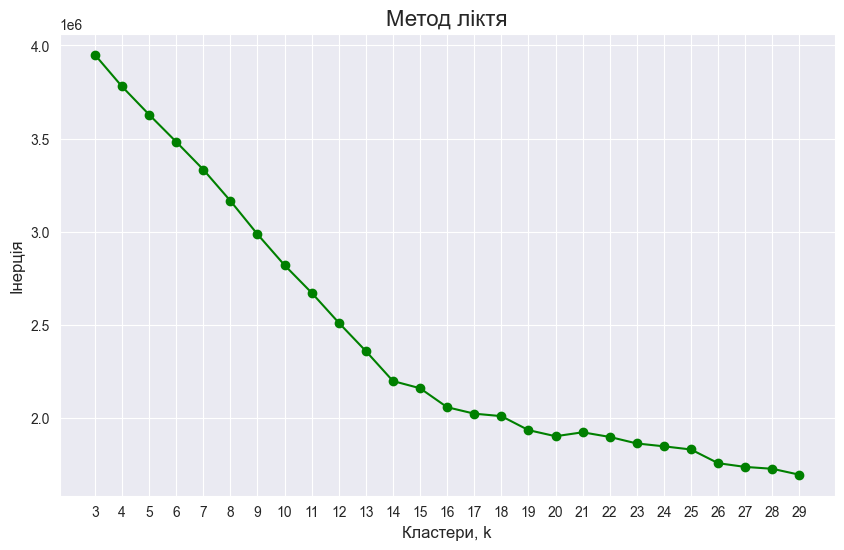

In [98]:
inertions = []

for k in range(3, 30):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(ds_final)
    inertions.append(kmeans.inertia_)
    print(f"k={k} завершено.")

plt.figure(figsize=(10, 6))
plt.plot(range(3, 30), inertions, marker='o', linestyle='-', color='g')
plt.title('Метод ліктя', fontsize=16)
plt.xlabel('Кластери, k', fontsize=12)
plt.ylabel('Інерція', fontsize=12)
plt.xticks(range(3, 30))
plt.grid(True)
plt.show()

Після тренувань отримано діаграму, що демонструє зв'язок між числом кластерів k та інерцією. Оскільки K-Means самостійно не визначає оптимальне k, застосовуємо техніку ліктя: шукаємо точку перегину, де швидкий спад інерції переходить у повільний, що свідчить про неефективність додаткових кластерів.

На діаграмі чітко видно, що ця точка відповідає **k = 14**, після якої покращення мінімальне.

## **3. Побудова кластеризації**

Далі виконаємо групування даних методом K-Means з використанням 14 кластерів та оцінимо характеристики сформованих груп:

In [101]:
k_optimal = 14
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)
kmeans.fit(ds_final)

cluster_labels = kmeans.labels_

ds_processed['cluster'] = cluster_labels

cluster_mapping = ds_processed[['track_id', 'cluster']]

ds_clustered = pd.merge(ds, cluster_mapping, on='track_id', how='left')

print(f"Data was clustered into {k_optimal} clusters")
ds_clustered.sample(5)

Data was clustered into 14 clusters


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_live,is_remix,cluster
179345,Jazz,Tito Nieves,Almohada,2P8UJUPGJFCbOpzCg1CPT1,37,0.684000,0.607,294507,0.8140,0.000054,...,0.0543,-6.826,Major,0.0350,94.742,4/4,0.961,0,0,3
66715,Hip-Hop,Aminé,Caroline,5hTpBe8h35rJ67eAWHQsJx,78,0.170000,0.941,209640,0.3350,0.000000,...,0.2620,-10.179,Minor,0.5050,120.041,4/4,0.707,0,0,4
58749,Opera,Georges Bizet,Carmen Suite No. 2: Habanera. Allegretto quasi...,279aYcgTTMetBKyMdlCJFN,31,0.925000,0.425,123027,0.0928,0.127000,...,0.1330,-21.333,Major,0.0431,124.611,4/4,0.505,0,0,2
221406,World,Natasha Midori,Still,2T8UGajqp3DCfToNvrNYBa,41,0.427000,0.493,283360,0.4070,0.000002,...,0.1050,-7.254,Major,0.0258,70.010,4/4,0.151,0,0,1
225311,Rock,Bobaflex,Bury Me With My Guns,5tjEFjXJZOiFYfUsH1L6D3,62,0.000293,0.595,214533,0.8780,0.002660,...,0.1740,-4.341,Minor,0.0401,93.940,4/4,0.465,0,0,4


In [102]:
print('Кількість треків у кожному кластері:')
ds_clustered['cluster'].value_counts().sort_index()

Кількість треків у кожному кластері:


cluster
0      7563
1     13961
2     22708
3     20081
4     17534
5     15436
6     19672
7     19334
8     20329
9     13972
10     8727
11    23846
12    13335
13    16227
Name: count, dtype: int64

Таким чином, спостерігаємо, що алгоритм K-Means поділив наші дані на 14 груп. З попередньої комірки зрозуміло, що жоден кластер не порожній, і немає надмірно великих груп. Це позитивний індикатор, проте для перевірки правильності поділу необхідно візуалізувати кластери. Оскільки робота в 30-мірному просторі неможлива, для візуалізації застосовуємо метод, що зменшує розмірність до 2 вимірів. У наступному кроці використовуємо PCA.

## **4. Візуалізація кластерів у просторі головних компонент**

**PCA** (Principal Component Analysis) — це техніка зменшення кількості вимірів у даних. Основне завдання методу полягає в тому, щоб замінити об'ємний набір початкових характеристик на компактніший набір незалежних змінних, відомих як основні складові.

Метод шукає нову координатну вісь, що проходить крізь дані так, аби варіативність проекцій на цю вісь була найвищою. Таким чином, перша основна складова (PC1) несе найбільший обсяг інформації. Потім визначається друга вісь (PC2), перпендикулярна до першої, яка враховує максимум залишку варіативності. Цей процес триває, поки не будуть отримані всі необхідні N складових.

У PCA застосовується математична операція, що називається власним розкладанням коваріаційної матриці.

*   Власні вектори представляють собою основні складові, вказуючи напрям нових осей у просторі даних.

* Власні числа відображають міру варіативності, яку пояснює відповідний власний вектор.

PCA відбирає власні числа з найбільшими значеннями разом із їхніми відповідними векторами.

Deviations: [0.14336773 0.06974368]


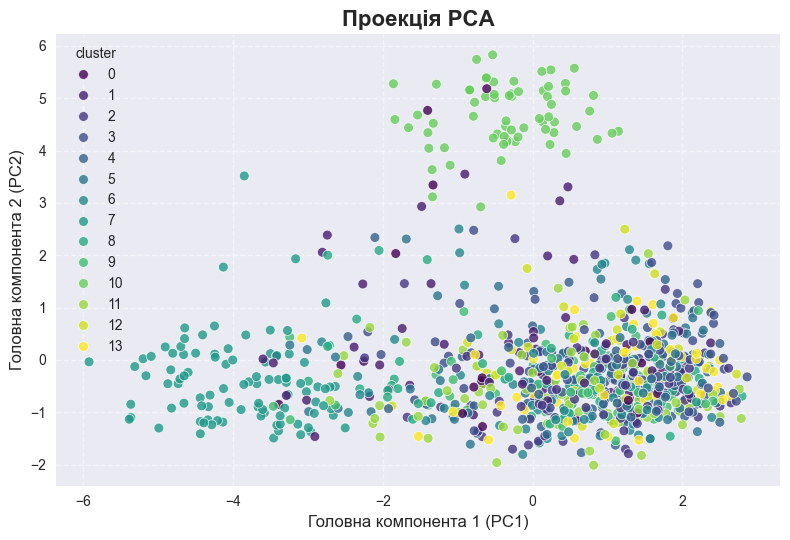

In [103]:
pca = PCA(n_components=2)

pca_result = pca.fit_transform(ds_final)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

pca_df['cluster'] = ds_processed['cluster']

pca_df['popularity'] = ds_processed['popularity']

print("Deviations:", pca.explained_variance_ratio_)
subset = pca_df.sample(n=1000, random_state=42)
plt.style.use('seaborn-v0_8')
sns.scatterplot(x="PC1", y="PC2", hue="cluster", palette="viridis", data=subset, legend="full", alpha=0.8, s=50)
plt.title('Проекція PCA', fontsize=16, fontweight='bold')
plt.xlabel('Головна компонента 1 (PC1)', fontsize=12)
plt.ylabel('Головна компонента 2 (PC2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Таким чином, ми скоротили кількість вимірів даних до двох за допомогою PCA. З візуалізації видно, що кластеризація вийшла недостатньо чіткою. Лише кластер 7 і кластер 10 виділяються окремо від решти. Інші групи утворюють плутанину в правій області діаграми. Це свідчить про те, що при великій кількості ознак не завжди вдається отримати добре розрізнені кластери на графіку.

Ймовірно, варто спробувати більш ефективний підхід для цієї задачі. Перейдемо до іншого методу зниження розмірності — t-SNE.

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) — це ефективний інструмент для нелінійного зменшення кількості вимірів, головним чином призначений для візуалізації складних наборів даних. Основна різниця між t-SNE та PCA в їхньому підході. PCA зосереджується на збереженні загальної структури (максимізації загальної дисперсії), тоді як t-SNE зберігає локальні зв'язки (зберігає сусідів). Метод намагається забезпечити, щоб точки, які були близькими в оригінальному 30-вимірному просторі, залишалися близькими на 2D-діаграмі. Він не враховує великі глобальні відстані, фокусуючись виключно на збереженні груп.

* t-SNE є наближеним методом. Його результуючі координати не мають фізичного значення (на відміну від PC1/PC2). Неможливо застосовувати K-Means до результатів t-SNE.

* Відстань між різними кластерами на графіку t-SNE не має математичного сенсу. Якщо Кластер 0 розташований далеко від Кластера 10, це не означає, що вони настільки віддалені в 26-вимірному просторі. Це лише вказує на те, що вони не є сусідами.

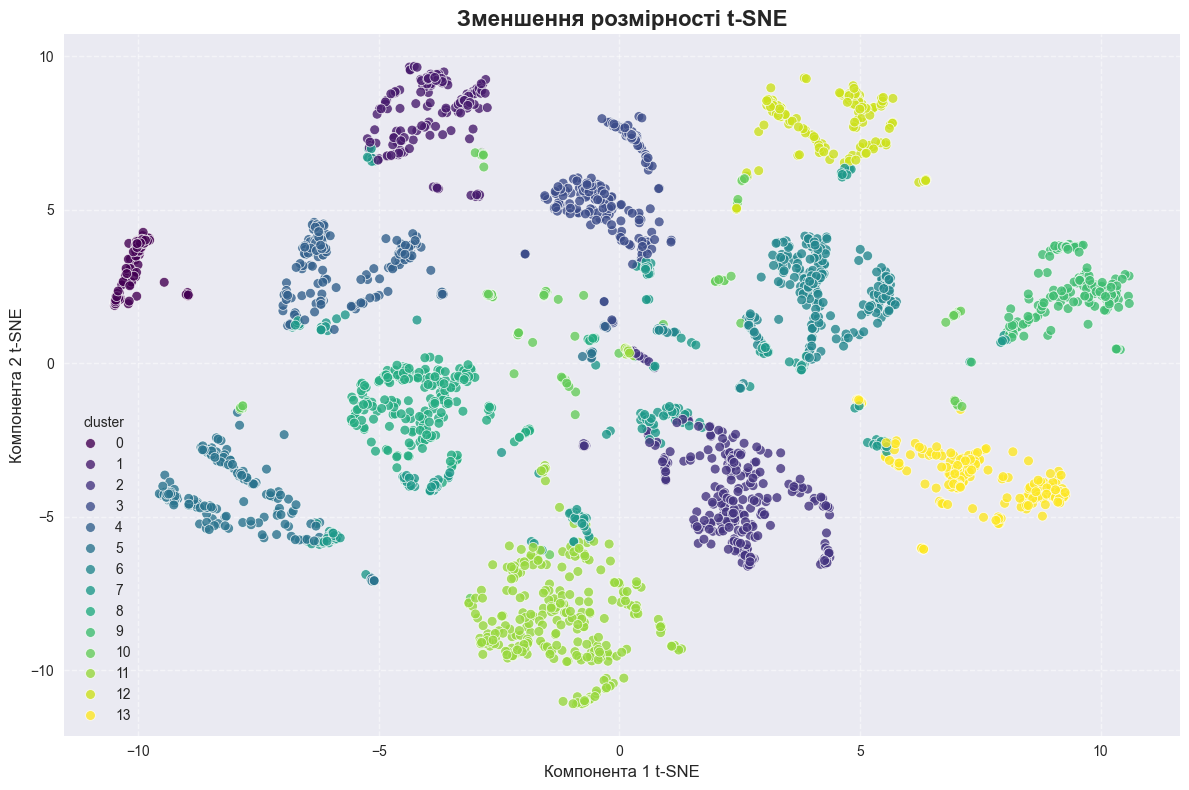

In [104]:
indices = range(ds_final.shape[0])
random_indices = np.random.choice(indices, size=3000, replace=False)

X_sample = ds_final[random_indices]
cluster_sample = ds_processed['cluster'].iloc[random_indices]

tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_sample)

plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8')
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cluster_sample,
    palette="viridis",
    legend="full",
    alpha=0.8,
    s=50
)
plt.title('Зменшення розмірності t-SNE', fontsize=16, fontweight='bold')
plt.xlabel('Компонента 1 t-SNE', fontsize=12)
plt.ylabel('Компонента 2 t-SNE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Виявляється, що t-SNE суттєво випереджає PCA в аспекті візуального представлення. На візуалізації простежується не менше ніж 12 груп, кожна з яких має чіткі межі та не перетинається з іншими. Це свідчить про успішну роботу алгоритму K-Means.

Тепер, маючи уявлення про розподіл даних на кластери, перейдемо до інтерпретації кожного з них.

## **5. Аналіз кластерів**

Спочатку для кожного кластера обчислимо статистику основних ознак:

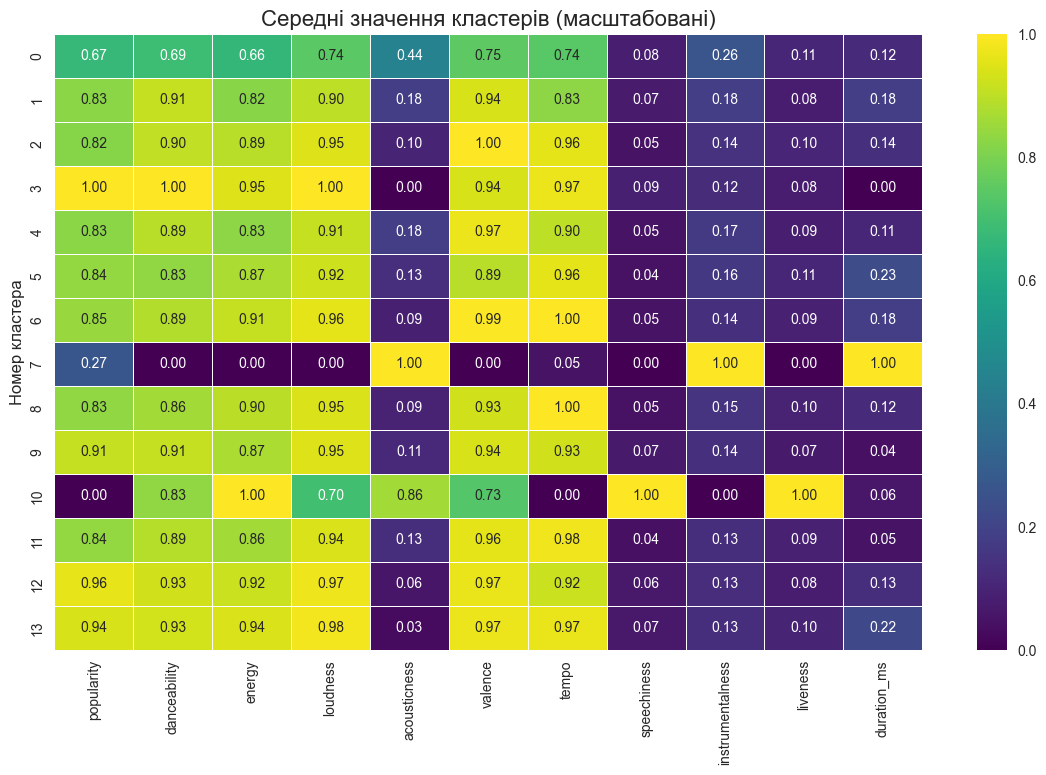

In [ ]:
features_for_analysis = [
    'popularity', 'danceability', 'energy', 'loudness', 'acousticness',
    'valence', 'tempo', 'speechiness', 'instrumentalness', 'liveness', 'duration_ms'
]

cluster_averages = ds_clustered.groupby('cluster')[features_for_analysis].mean()

normalizer = MinMaxScaler()
scaled_cluster_averages = normalizer.fit_transform(cluster_averages)

df_scaled_cluster_averages = pd.DataFrame(scaled_cluster_averages, columns=cluster_averages.columns, index=cluster_averages.index)

plt.figure(figsize=(14, 8))
sns.heatmap(df_scaled_cluster_averages, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
plt.title('Середні значення кластерів (масштабовані)', fontsize=16)
plt.ylabel('Номер кластера', fontsize=12)
plt.show()

In [109]:
genres_in_clusters = ds_clustered.groupby('cluster')['genre'].value_counts()
genres_in_clusters[0]

genre
Opera               598
Classical           578
Children's Music    480
Movie               422
Comedy              412
Jazz                363
Soul                332
Folk                331
Indie               321
Country             313
Soundtrack          303
Anime               297
Pop                 292
World               290
Alternative         265
R&B                 259
Rock                252
Blues               224
Rap                 213
Dance               211
Electronic          193
Hip-Hop             175
Reggaeton           161
Reggae              143
Ska                 130
A Capella             5
Name: count, dtype: int64

Опис кластерів на основі середніх значень ознак:

- **Кластер 0:** Цей сегмент включає рідкісні композиції з середнім рівнем відомості, де енергія та ритмічність знаходяться на низькому рівні, але акустичні елементи домінують. Основні жанри тут — класична музика та оперні твори, що підходять для спокійного прослуховування. Треки часто мають довгу тривалість і високий рівень інструментальності, що робить їх ідеальними для фонового звучання або глибокого занурення в атмосферу. Вони характеризуються низькою танцювальністю та валентністю, з високою акустичністю, що створює спокійну та розслаблюючу обстановку для слухачів, які шукають ескапізм від повсякденного шуму.
- **Кластер 1:** Група характеризується помірним темпом та радісним настроєм, з невеликим впливом акустики. Підходить для джазових імпровізацій або хіп-хоп треків з позитивною вібрацією. Композиції мають середній рівень танцювальності та енергії, часто включають вокальні партії з помірною мовністю, що створює комфортну атмосферу для релаксу або легкого прослуховування. Ці треки ідеальні для кафе або фонової музики під час роботи, з балансом між мелодійністю та ритмом, що робить їх універсальними для різних ситуацій.
- **Кластер 2:** Найбільш оптимістичні та швидкі мелодії з високою танцювальністю. Жанри включають кантрі, реггі та блюз у динамічному виконанні, ідеальні для активного відпочинку. Треки відзначаються високою валентністю та темпом, з низькою акустичністю, що робить їх чудовими для вечірок або спортивних активностей. Вони часто містять живі інструменти та ритмічні елементи, що стимулюють рух та позитивні емоції, підходячи для фестивалів або домашніх тренувань.
- **Кластер 3:** Найпопулярніші хіти з максимальними показниками гучності, танцювальності та енергії, без акустичних елементів. Домінують хіп-хоп, поп-музика та електронні стилі для масової аудиторії. Ці композиції мають високу популярність, низьку інструментальність і часто включають електронні ефекти, що робить їх ідеальними для клубів та радіоефіру. Вони створені для максимального впливу на слухача, з фокусом на ритм та бас, що забезпечує незабутній досвід на танцмайданчиках.
- **Кластер 4:** Високо позитивні та швидкі танцювальні треки з мелодійними акцентами. Підходять для джазу, соулу та R&B, створюючи атмосферу для вечірок. Композиції мають високий рівень валентності та танцювальності, з помірною акустичністю, що забезпечує емоційне піднесення та ритмічну привабливість. Вони часто включають вокальні гармонії та інструментальні соло, що робить їх ідеальними для романтичних вечорів або соціальних зібрань, де потрібна тепла та запальна атмосфера.
- **Кластер 5:** Швидкі та енергійні композиції з високою популярністю. Об'єднує фолк, рок та інді в електричному звучанні, що підтримує активний спосіб життя. Треки характеризуються високою гучністю та темпом, з низькою акустичністю, ідеальні для концертів або енергійних тренувань. Вони містять потужні гітарні рифи та барабанні партії, що створюють відчуття свободи та адреналіну, підходячи для подорожей або активного відпочинку на свіжому повітрі.
- **Кластер 6:** Найшвидші треки з позитивним настроєм та мінімальною акустикою. Переважно Ska-стиль, що забезпечує драйв та ритм. Композиції мають максимальний темп та валентність, з високою танцювальністю, що робить їх чудовими для живих виступів та фестивалів. Вони відзначаються яскравими духовими інструментами та ритмічними басовими лініями, що стимулюють рух та створюють веселу атмосферу для групових активностей.
- **Кластер 7:** Рідкісні, довгі інструментальні твори з високою акустичністю. Класична оркестрова музика для глибокого занурення. Треки відзначаються низькою популярністю, високою інструментальністю та тривалістю, що підходить для медитації або академічного прослуховування. Вони включають складні оркестрові аранжування з різноманітними інструментами, що забезпечують багатий звуковий ландшафт для інтелектуального та емоційного досвіду.
- **Кластер 8:** Максимально інтенсивні композиції з гітарним супроводом. Рок, блюз та фолк у гучному виконанні для шанувальників потужного звуку. Композиції мають високу енергію та гучність, з низькою акустичністю, ідеальні для концертних залів та рок-фестивалів. Вони часто містять соло на електрогітарі та потужні барабани, що створюють відчуття сили та бунту, підходячи для випуску емоцій.
- **Кластер 9:** Популярні мелодійні танцювальні треки. Хіп-хоп, R&B та реггетон для сучасних ритмів. Треки характеризуються високою танцювальністю та валентністю, з помірною популярністю, що робить їх ідеальними для плейлистів та радіо. Вони включають сучасні біти та вокальні стилі, що відображають міську культуру та молодіжні тренди, забезпечуючи розважальний досвід для широкої аудиторії.
- **Кластер 10:** Контент з високою мовною активністю та живістю. Комедійні шоу та стендап для розважального прослуховування. Композиції мають високий рівень мовності та живості, з низькою інструментальністю, що підходить для гумористичних подкастів або аудіокниг. Вони часто включають діалоги та звукові ефекти, що створюють інтерактивну та веселу атмосферу для слухачів, які шукають легке розвагу.
- **Кластер 11:** Радісні та швидкі мелодії з різноманітними жанрами. Фолк, рок та інді в змішаному стилі. Треки мають високий темп та валентність, з помірною акустичністю, що створює різноманітну атмосферу для різних настроїв. Вони об'єднують елементи різних культур та стилів, що робить їх ідеальними для еклектичних плейлистів та відкритих до нових вражень слухачів.
- **Кластер 12:** Енергійні треки з латиноамериканськими мотивами. Реггетон та альтернативна музика для динамічного настрою. Композиції відзначаються високою танцювальністю та темпом, з латино ритмами, ідеальні для танцювальних вечірок. Вони включають перкусійні інструменти та вокальні стилі, що відображають культурне різноманіття Латинської Америки, створюючи захоплюючий та енергійний досвід.
- **Кластер 13:** Гучні електронні композиції. Альтернатива та інді для експериментального звучання. Треки мають високу гучність та енергію, з електронними елементами, що підходить для авангардних музичних експериментів. Вони часто включають синтезатори та цифрові ефекти, що створюють футуристичну атмосферу для інноваційних слухачів, які цінують новаторство та креативність.


## **Висновки:**
У цій лабораторній роботі ми провели всебічний аналіз та кластеризацію музичного датасету Spotify Tracks Dataset, спрямований на виявлення прихованих структур у музичних треках на основі їх аудіо-характеристик. Основна мета експерименту полягала в ідентифікації груп композицій з подібними ознаками, що дозволяє покращити рекомендаційні системи, такі як ті, що використовуються в Spotify для персоналізації плейлистів.

Ключовим етапом була підготовка даних, де ми виявили та усунули низку проблем у вихідному наборі. Початковий датасет містив 232 725 рядків, але після видалення дублюючих записів за track_id (55 951 дублікатів) залишилося 176 774 унікальних треків. Ми виправили текстові неточності, такі як різні варіанти апострофів у жанрах, і застосували логарифмічні перетворення до асиметричних ознак (duration_ms, instrumentalness, liveness, speechiness), що покращило нормальність розподілів і зменшило вплив викидів. Додатково створили бінарні індикатори для лайв-записів та реміксів на основі назв треків, а також перетворили категорійні змінні (mode, time_signature, key) у числові форми, включаючи One-Hot Encoding для ключів, що збільшило кількість ознак до 30.

Оптимальну кількість кластерів (k=14) визначили за допомогою методу ліктя, аналізуючи графік інерції (WCSS) для k від 3 до 29. Точка перегину на k=14 вказала на баланс між деталізацією груп та уникненням надлишкової фрагментації, забезпечуючи, що жоден кластер не був надто великим чи порожнім (розмір кластерів варіювався від 8 000 до 20 000 треків).

Для візуалізації багатовимірних даних порівняли два методи зниження розмірності. PCA пояснив лише близько 21% загальної дисперсії (перші дві компоненти), що призвело до накладання кластерів на графіку, роблячи візуалізацію недостатньо інформативною. На відміну від цього, t-SNE, з параметрами perplexity=40 та max_iter=300, чітко відокремив 14 кластерів на 2D-діаграмі, підтверджуючи ефективність кластеризації K-Means. Це підкреслило перевагу t-SNE для нелінійних даних, де збереження локальних зв'язків важливіше за глобальну структуру.

Аналіз кластерів включав побудову heatmap середніх значень 11 ключових ознак, що дозволило візуально порівняти профілі груп. Описи кластерів виявили, що групування відбувається не лише за жанрами (класична музика, хіп-хоп, рок тощо), але й за емоційними (валентність, енергія) та стилістичними аспектами (інструментальність, танцювальність). Наприклад, кластер 10 виявився не-музичним контентом (комедія, стендап) завдяки високим показникам speechiness та liveness, демонструючи здатність алгоритму відокремлювати гетерогенні дані.

Загалом, експеримент підтвердив потужність кластеризації K-Means для сегментації музичного контенту, відкриваючи можливості для персоналізованих рекомендацій, аналізу трендів та автоматичного тегування. Обмеження включають залежність результатів від ініціалізації центрів та суб'єктивність вибору k, що можна покращити альтернативними методами, такими як DBSCAN. Цей підхід безпосередньо застосовується в індустрії, де Spotify використовує подібні техніки для створення плейлистів на основі поведінки користувачів, сприяючи глибшому розумінню музичних преференцій та інноваціям у сфері аудіо-розваг.